In [1]:
#---------------------------------- IMPORTING!! ---------------------------------- 

%matplotlib notebook
import rebound
import numpy as np
import sys
from IPython.display import display, clear_output
from math import sqrt, log10, sin, cos, atan
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
#---------------------------------- DEFINING!! ---------------------------------- 

# All distances in A.U.
AU = 1.5e13
mh = 4.0e6
mb = 3.76e9/mh
md = 6.0e10/mh
mha = 1.0e12/mh
ab = 2.0e7
rh = 4.125e9
rsun = 7.0e10/AU
msun = 2.0e33
rp = 1.0
ad = 5.7e8
bd = 6.2e7
G = 6.67408e-8
scale = 1.6e9

# Galaxy potential taken from http://adsabs.harvard.edu/abs/2014ApJ...793..122K,
# Note: There is a typo in that paper where "a_d" is said to be 2750 kpc, it should be 2.75 kpc.

def migrationAccel(reb_sim):
    r = sqrt(ps[1].x**2+ps[1].y**2+ps[1].z**2)
    rho2 = ps[1].x**2+ps[1].y**2
    zbd = sqrt(ps[1].z**2+bd**2)
    logterm = np.log(1.0+(r/rh))
    rterm = (r+rh)*(r**2)
    
    func = lambda r,c,k: ((1.0/np.pi)*atan((r-c)/k) + 0.5)
    f3 = lambda r: func(r,1.0e8,1.0e5)
    
    ps[1].ax += -mb*ps[1].x/(r*(ab+r)**2) -\
                md*ps[1].x/(rho2+(ad+zbd)**2)**1.5 +\
                f3(r)*mha*ps[1].x*((logterm/r**3)-(1.0/rterm))
    ps[1].ay += -mb*ps[1].y/(r*(ab+r)**2) -\
                md*ps[1].y/(rho2+(ad+zbd)**2)**1.5 +\
                f3(r)*mha*ps[1].y*((logterm/r**3)-(1.0/rterm))
    ps[1].az += -mb*ps[1].y/(r*(ab+r)**2) -\
                md*ps[1].y/(rho2+(ad+zbd)**2)**1.5 +\
                f3(r)*mha*ps[1].z*((logterm/r**3)-(1.0/rterm))
    #print(-mb*ps[1].x/(r*(ab+r)**2), -md*ps[1].x/(rho2+(ad+zbd)**2)**1.5,
          #f3(r)*mha*ps[1].x*((logterm/r**3)-(1.0/rterm)))
    #sys.exit()
            
# xi = #constant set by local stellar density

# # from Salpeter's equation: 
# # Xi(m) =  xi/(m**2.35)
# # CDF(x) = xi/(x**1.35) when we integrate Xi(m) from -infty to x, and 
# #produces a probability between [0,1].
# # star_func is found by solving for m when given a probability 0 <= x <= 1:
# # this outputs a star mass measured in solar masses
# star_func = lambda x: (x/xi)**1.35 


In [3]:
#---------------------------------- INTEGRATING!! ---------------------------------- 
Nstars = 1
#nfrag = rnd.randint(100, 300)
nfrag = 20
Nout = 200

t_start = 0
t_end = 10000

posx = [[[] for y in range(nfrag)] for x in range(Nstars)]
posy = [[[] for y in range(nfrag)] for x in range(Nstars)]
posz = [[[] for y in range(nfrag)] for x in range(Nstars)]

for star in tqdm(range(Nstars)):
    # Randomly drawn mass of star disrupted, fraction of star mass lost in disruption, 
    # number of fragments, and initial 3D angle of outgoing stellar debris

#     m_star = star_func(rnd.random())
#     print m_star
#     percentage_lost = rnd.random()
#     m_deb = m_star*percentage_lost
#     m_frag = m_deb/nfrag

    # Velocities are set to be just a little bit hyperbolic.
    rads = [float(x)/float(nfrag-1)*rsun for x in range(nfrag)]
    vels = [
        #sqrt(G*mh*msun/(rp*AU))/AU*
        (sqrt(2.0 + float(x)/rp)) for x in rads]
    for i, vel in enumerate(vels):
        # Set up simulation
        sim = rebound.Simulation()
        sim.integrator = "ias15"
        sim.add(m=1.0)
        
        #set position of fragment; random sphere point picking
        u1 = rnd.uniform(-1.0,1.0)
        th1 = rnd.uniform(0., 2.*np.pi)
        
        u2 = rnd.uniform(-1.0,1.0)
        th2 = rnd.uniform(0., 2.*np.pi)
        
        posvec = [sqrt(1.0-(u1)**2)*cos(th1),sqrt(1.0-(u1)**2)*sin(th1),u1] #position v
        vec2 = [sqrt(1.0-(u2)**2)*cos(th2),sqrt(1.0-(u2)**2)*sin(th2),u2]
        
        velvec = np.cross(posvec, vec2)
        n = np.linalg.norm(velvec)
        velvec = [vel*v/n for v in velvec]

        #adding particle
        sim.add(m=0.0,x=posvec[0],y=posvec[1],z=posvec[2],vx=velvec[0],\
                vy=velvec[1],vz=velvec[2])
        sim.N_active = 1
        sim.additional_forces = migrationAccel

        ps = sim.particles

        times = np.linspace(0.0, 200.0*((ab)**(1.5)/sqrt(mb))*2.*np.pi, Nout)
        for ti, time in enumerate(times):
            #print(time)
            sim.integrate(time, exact_finish_time=1)
            posx[star][i].append(ps[1].x/scale)
            posy[star][i].append(ps[1].y/scale)
            posz[star][i].append(ps[1].z/scale)
    
    t_start += 10000
    t_end += 10000

100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


<IPython.core.display.Javascript object>


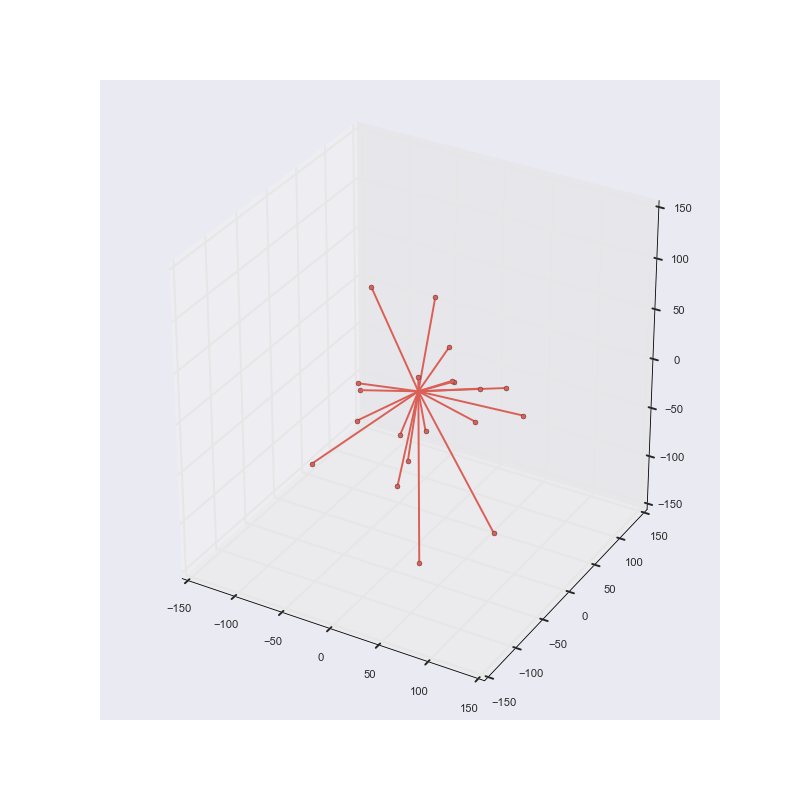

In [4]:
#---------------------------------- PLOTTING!! ---------------------------------- 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = sns.color_palette("hls", Nstars).as_hex()
for star in range(Nstars):
    for i in range(nfrag):
        ax.plot(posx[star][i],posy[star][i],posz[star][i], c = colors[star]);
        ax.scatter([posx[star][i][-1]],[posy[star][i][-1]],[posz[star][i][-1]],c = colors[star]);

<IPython.core.display.Javascript object>


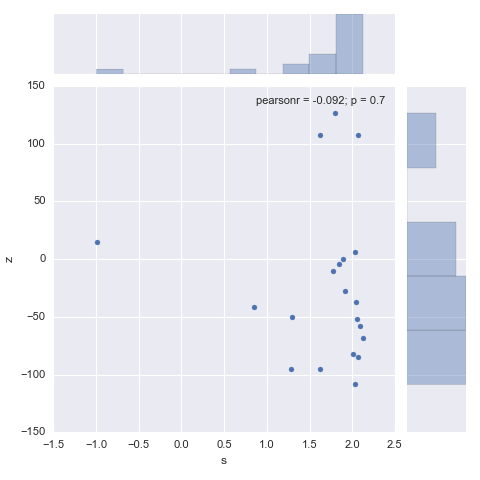

<IPython.core.display.Javascript object>


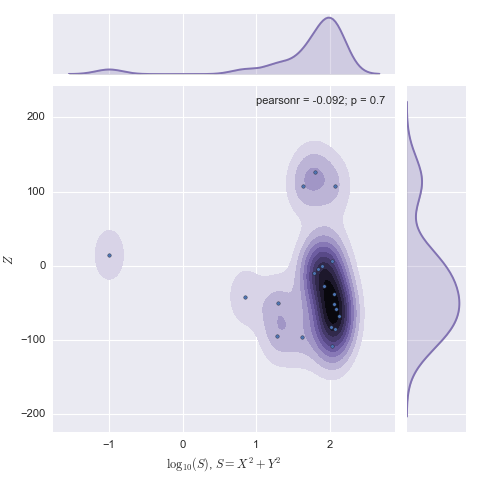

In [5]:
#---------------------------------- VISUALIZING!! ---------------------------------- 
data = []
for star in range(Nstars):
    for i in range(nfrag):
        end = len(posx[star][i])
        point = [log10(sqrt(posx[star][i][end - 1]**2 + posy[star][i][end - 1]**2)), posz[star][i][end - 1]]
        data.append(point)
        
fragdata = np.array([point for point in data])
df = pd.DataFrame(fragdata, columns=["s", "z"])

#Scatter plots
sns.jointplot(x="s", y="z", data=df);

#Density plots
# sns.jointplot(x="x", y="y", data=df, kind="kde");

g = sns.jointplot(x="s", y="z", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="b", s=10, marker="o")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$\log_{10}(S)$, $S = X^2 + Y^2$", "$Z$");